In [51]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.pyplot import imshow
import pandas as pd

In [52]:
numcat = 6 #number of categories
categories = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

In [53]:
directory = r'./Medical_MNIST/'
train, test = [], []
for i in range(numcat):
    imagearray = []
    for image_raw in os.listdir(directory + categories[i]):
        image_np = (np.array(Image.open(os.path.join(directory + categories[i], image_raw))).flatten())
        image = np.append(image_np, i)
        imagearray.append(image.astype('uint8'))
        
    train += imagearray[0:int(0.8*len(imagearray))]
    test += imagearray[int(0.8*len(imagearray)):]
data = np.array(imagearray)
train = np.array(train)
test = np.array(test)

KeyboardInterrupt: 

In [ ]:
np.save('Medical_train.npy', train)
np.save('Medical_test.npy', test)

In [ ]:
train = np.load('Medical_train.npy')
test = np.load('Medical_test.npy')
#shuffle train and test sets
np.random.shuffle(train)
np.random.shuffle(test)
#splitting into x and y - for both train and test sets
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

cols = x_train.shape[1]

for i in range(cols):
    train_col = x_train[:,i]
    train_mean = train_col.mean()
    train_std = train_col.std()
    x_train[:,i] = (x_train[:,i] - train_mean)/train_std
    
    test_col = x_test[:,i]
    test_mean = test_col.mean()
    test_std = test_col.std()
    x_test[:,i] = (x_test[:,i] - test_mean)/test_std

In [ ]:
train_ones = np.ones((x_train.shape[0],1), dtype=x_train.dtype)
X = np.append(x_train,train_ones,axis=1)
print(X.shape) 
test_ones = np.ones((x_test.shape[0],1), dtype=x_test.dtype)
X_test = np.append(x_test,test_ones,axis=1)
print(X_test.shape)
Y = np.reshape(y_train,(y_train.shape[0],1))
print(Y.shape)
Y_test = np.reshape(y_test,(y_test.shape[0],1))
print(Y_test.shape)

In [ ]:
classes = 6

Y_oh = np.zeros((Y.shape[0],classes))

for i in range(Y.shape[0]):
    Y_oh[i,Y[i]] = 1
    
Y_test_oh = np.zeros((Y_test.shape[0],classes))

for i in range(Y_test.shape[0]):
    Y_test_oh[i,Y_test[i]] = 1

print(Y_oh)
print(Y)

In [ ]:
#subtract the maximum of each array to stabilise exponential calculation using the identity softmax(x - c) = softmax(x)

def softmax(Z):
    prob = np.zeros(Z.shape)
    
    for i in range(Z.shape[0]):
        Z_stable = Z[i] - max(Z[i])
        exp = np.exp(Z_stable)
        total = np.sum(exp)
        prob[i] = exp/total
    return prob

In [ ]:
# W = np.random.rand(4097,6)

#add a small positive value to make sure log does not overflow

def loss(W,X,Y):
    Z = np.matmul(X,W)
    # dim Z = (47163, 6)
    p = softmax(Z)
    
    #loss = -y(i)logp(i) or y product with p
    loss = 0
    
    epsilon = 1e-5
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if(Y[i,j] != 0):
                loss = loss - np.log(p[i,j] + epsilon)
    
    return loss/Y.shape[0]

In [ ]:
def gradient(W,X,Y):
    Z = np.matmul(X,W)
    p = softmax(Z)
    
    #dim p/Y = (47163,6)
    #dim X = (47163,4097)
    grad = np.matmul(X.T,(p-Y))
    
    return grad

In [ ]:
def sgd(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient(W,X,Y)
        W = W - rate*grad
        train_loss.append(loss(W,X,Y))
        test_loss.append(loss(W,X_test,Y_test))
    return W, train_loss, test_loss

In [54]:
num_iter = 20
rate = 0.01
W = np.random.rand(4097,6)

print(W)

W, train_loss, test_loss = sgd(W,X,Y_oh,X_test,Y_test_oh,rate,num_iter)

print(W)

[[0.20848353 0.80223334 0.62559281 0.4740737  0.41859119 0.55905664]
 [0.94995364 0.09376482 0.02115448 0.34976762 0.97691495 0.3484527 ]
 [0.84157292 0.31229206 0.70651364 0.8735007  0.80192211 0.14514101]
 ...
 [0.67177902 0.05146727 0.99342309 0.60160902 0.72562506 0.3381994 ]
 [0.31130506 0.98963881 0.63799808 0.32740334 0.19774399 0.33055181]
 [0.32793107 0.668731   0.86116513 0.43798134 0.02703937 0.93274726]]
[[-4.41091662e+02  5.15798044e+03 -1.95708877e+04  2.39791278e+04
  -6.54277550e+03 -2.57926530e+03]
 [-3.88963990e+02  1.21392287e+04 -1.85809249e+04  1.98416041e+04
  -1.08632487e+04 -2.14495527e+03]
 [-7.87557861e-01 -2.50750471e+02  1.51953431e+03 -1.22712235e+03
  -1.03203270e+01 -2.68726628e+01]
 ...
 [-2.19991303e+02  5.00828205e+03 -1.96860910e+04  2.17693757e+04
  -4.37437908e+03 -2.49381431e+03]
 [-2.40698168e+02  5.02178002e+03 -2.04583390e+04  1.92336961e+04
  -9.42459134e+02 -2.61118522e+03]
 [ 1.57787003e+03 -1.00763456e+03  1.35129563e+03 -1.14965355e+03
  -5

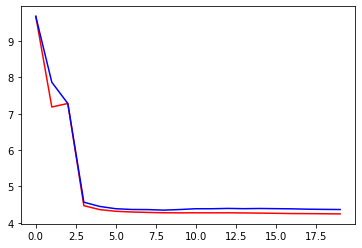

In [55]:
plt.plot(train_loss, 'r')
plt.plot(test_loss, 'b')
plt.show()